# Experiment 3: Smoothed Support Vector Classifer on Iris Dataset

In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

from importlib import reload
from mlxtend.plotting import plot_decision_regions
import influence
reload(influence)

from data import Datafile, load_data
from influence.emp_risk_optimizer import EmpiricalRiskOptimizer
from influence.plot_utils import compare_with_loo
from influence.plot_utils import param_cross_comparison
from influence.closed_forms import I_loss_RidgeCf
from models.regularized_regression import RegularizedRegression
from models.hyperplane_clf import BinaryLogisticRegression
from models.hyperplane_clf import SmoothedSupportVector
from sklearn.preprocessing import StandardScaler

In [348]:
def compare_with_loo(influences, loo_diff, n_samples,
                     method_names=('brute-force', 'cg')):
    n_methods = len(influences)
    fig, axes = plt.subplots(2, n_methods, figsize=(n_methods*10, 20))
    leave_tr, n_te = influences[0].shape
    # frame_trunc = np.percentile(loo_diff, trunc)
    for m in range(n_methods):
        for j in range(n_te):
            axes[0, m].plot(
                influences[m][:, j]/n_samples,
                loo_diff[:, j], 'o', color='black')
            axes[1, m].plot(
                influences[m][:, j]/n_samples,
                loo_diff[:, j] + j, 'o')

        axes[0, m].update({
            'title': 'Influence {} V.S. Numerical LOO'.format(method_names[m]),
            'xlabel': 'Influence I_loss/-n',
            'ylabel': 'Numerical LOO'
            # 'xlim': (-frame_trunc, frame_trunc),
            # 'ylim': (-frame_trunc, frame_trunc)
        })

        axes[1, m].update({
            'title': 'Colored & Translated by different Validation Points',
            'yticks': []})
    return fig, axes

def param_cross_comparison(influences, loo_diff,
                           n_samples, param):
    n_methods = len(influences)
    assert n_methods == len(loo_diff) == len(param) and n_methods > 1

    fig, axes = plt.subplots(2, n_methods, figsize=(n_methods * 8, 20))
    leave_tr, n_te = influences[0].shape
    # frame_trunc = np.percentile(loo_diff, trunc)
    for m in range(n_methods):
        for j in range(n_te):
            axes[0, m].plot(
                influences[m][:, j] / n_samples,
                loo_diff[m][:, j], 'o', color='black')
            axes[1, m].plot(
                influences[m][:, j] / n_samples,
                loo_diff[m][:, j] + j, 'o')

        axes[0, m].update({
            'title': 'Influence with param={} V.S. Numerical LOO'.format(param[m]),
            'xlabel': 'Influence I_loss/-n',
            'ylabel': 'Numerical LOO'
            # 'xlim': (-frame_trunc, frame_trunc),
            # 'ylim': (-frame_trunc, frame_trunc)
        })

        axes[1, m].update({
            'title': 'Colored & Translated by different Validation Points',
            'yticks': []})
    return fig, axes

# Leave-one-out Loss vs. Influence Loss vs. CG Influence Loss

By using Iris data, we can see that from the graph the influence loss and loo loss aligns on a straight line, which shows that influence loss approximates leave-oue-out loss well in LinearSVM model.

In [270]:
# [6, 47]
X_train, X_test, y_train, y_test, test_indices = load_data(
    Datafile.Iris, test_config=[6, 21])
n_tr, p = X_train.shape
n_te, _ = X_test.shape
y_train[y_train==0]=-1 
y_test[y_test==0]=-1
print(n_tr, p)

init_eta = 1e-2
batch_size = 50
train_iter = 50000
traceback_checkpoint = 45000
loo_extra_iter = 5000
decay_epochs = (10000, 20000)
checkpoint_iter = traceback_checkpoint-1
iter_to_switch_off_minibatch=20000
iter_to_switch_to_sgd=40000
C = 1.0
t = 0.01
# LOO a on random set of training indices, otherwise too slow
leave_indices = None
#assert not set(test_indices) & set(leave_indices)
#print(test_indices)
print(leave_indices)

X_train shape: (98, 4)
y_train shape: (98, 1)
X_test shape: (2, 4)
y_test shape: (2, 1)
98 4
None


In [271]:
tf.reset_default_graph()
model = SmoothedSupportVector(
    model_name='SmoothHinge-Notebook',
    init_eta=init_eta,
    decay_epochs=decay_epochs,
    batch_size=batch_size,
    C=C,
    t=t
)

model.fit(
    X_train, y_train,
    n_iter=train_iter,
    verbose=1,
    iter_to_switch_off_minibatch=iter_to_switch_off_minibatch,
    iter_to_switch_to_sgd=iter_to_switch_to_sgd,
    traceback_checkpoint=traceback_checkpoint
)

Step 0, Epoch 0: loss = 1.00000000 (0.094 sec)
Step 1000, Epoch 510: loss = 0.32673654 (0.000 sec)
Step 2000, Epoch 1020: loss = 0.30677062 (0.000 sec)
Step 3000, Epoch 1530: loss = 0.32029426 (0.000 sec)
Step 4000, Epoch 2040: loss = 0.23379165 (0.016 sec)
Step 5000, Epoch 2551: loss = 0.31615320 (0.000 sec)
Step 6000, Epoch 3061: loss = 0.30158374 (0.000 sec)
Step 7000, Epoch 3571: loss = 0.32789421 (0.016 sec)
Step 8000, Epoch 4081: loss = 0.26186469 (0.000 sec)
Step 9000, Epoch 4591: loss = 0.25749460 (0.016 sec)
Step 10000, Epoch 5102: loss = 0.28263927 (0.000 sec)
Step 11000, Epoch 5612: loss = 0.26489556 (0.000 sec)
Step 12000, Epoch 6122: loss = 0.25193903 (0.000 sec)
Step 13000, Epoch 6632: loss = 0.30969140 (0.000 sec)
Step 14000, Epoch 7142: loss = 0.31703874 (0.000 sec)
Step 15000, Epoch 7653: loss = 0.21365559 (0.000 sec)
Step 16000, Epoch 8163: loss = 0.26155204 (0.000 sec)
Step 17000, Epoch 8673: loss = 0.33283803 (0.016 sec)
Step 18000, Epoch 9183: loss = 0.27773088 (0.

SmoothHinge-Notebook(init_eta=0.01,batch_size=50,decay_epochs=(10000, 20000),C=1.0,t=0.01)

In [272]:
y_pred = model.predict(X_train)
print("Train accuracy:", np.sum(y_pred == y_train)/n_tr)

Train accuracy: 0.9489795918367347


In [327]:
I_loss_bf = model.influence_loss(
    X_test, y_test,
    method='brute-force',
)
# I_loss_bf[leave_indices,:]/n_tr

Fetch training loss gradients (0.082 sec)


In [328]:
I_loss_cg = model.influence_loss(
    X_test, y_test,
    method='cg',
    tol=1e-7, 
    max_iter=1000
)

Fetch training loss gradients (0.088 sec)
CG Objective: -0.61893487
CG Objective: -0.93221796
CG Objective: -0.9666754
CG Objective: -0.9685458
CG Objective: -0.9686533
CG Objective: -0.96865374
         Current function value: -0.968654
         Iterations: 6
         Function evaluations: 99
         Gradient evaluations: 93
         Hessian evaluations: 23
CG Objective: -0.0168116
CG Objective: -0.016953876
CG Objective: -0.016953878
         Current function value: -0.016954
         Iterations: 3
         Function evaluations: 67
         Gradient evaluations: 58
         Hessian evaluations: 13


In [275]:
loo_diff = model.leave_one_out_refit(
    X_test, y_test,
    n_iter=loo_extra_iter,
    iter_to_load=checkpoint_iter,
    leave_indices=leave_indices,
)

INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
LOO Fold 0: loss = 0.28993389 (3.751 sec)
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
LOO Fold 9: loss = 0.28942961 (3.391 sec)
INFO:tensorflow:Restoring parameters from outp

INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
LOO Fold 90: loss = 0.28993389 (3.438 sec)
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999


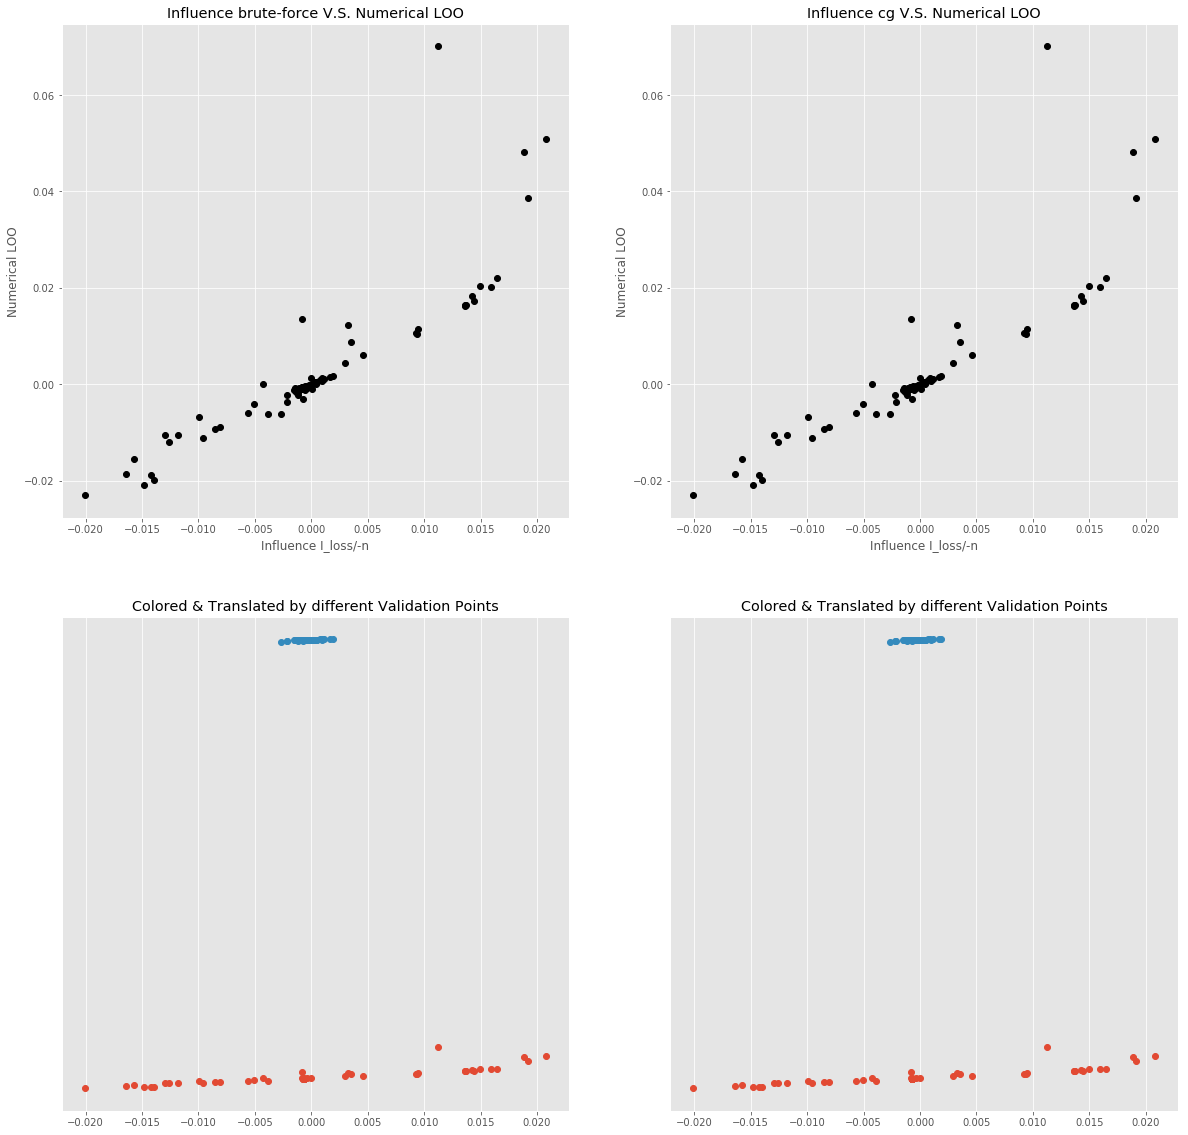

In [365]:
fig, axes = compare_with_loo(
    [I_loss_bf,
     I_loss_cg],
    loo_diff, n_samples=n_tr
)

In [329]:
a, b = loo_diff.shape
for j in range(n_te):
    print("CG Test Point %d Correlation: %.4f" % (j, np.corrcoef(
        I_loss_cg[:, j], loo_diff[:, j])[0][1]))
print("CG Overall Correlation: %.4f" % np.corrcoef(
        I_loss_cg[:, :].reshape(a*b,),
        loo_diff.reshape(a*b,))[0][1])

CG Test Point 0 Correlation: 0.8704
CG Test Point 1 Correlation: 0.9103
CG Overall Correlation: 0.8654


In [330]:
a, b = loo_diff.shape
for j in range(n_te):
    print("BF Test Point %d Correlation: %.4f" % (j, np.corrcoef(
        I_loss_bf[:, j], loo_diff[:, j])[0][1]))
print("BF Overall Correlation: %.4f" % np.corrcoef(
        I_loss_bf[:, :].reshape(a*b,),
        loo_diff.reshape(a*b,))[0][1])

BF Test Point 0 Correlation: 0.8704
BF Test Point 1 Correlation: 0.9103
BF Overall Correlation: 0.8654


# Smooth Hinge with different t

In this section, we will see that that using smooth approximations to non-differentiable influence functions can also predict the behavior of the original leave-one-out loss. 

For Support Vector Classifier, the loss function $Hinge(s)= max(0, 1-s)$ is not differentiable. So similar to the idea in the paper, we approximate the hinge loss function with smooth hinge function $SmoothHinge(s, t) = tlog(1+exp(\frac{1-s}{t}))$. 

We try different $t$ and find out that when t=0.01, loo_loss vs. influence loss has the largest correlation. Even though we expect that the correlation increases as t increases, we can see that it is not the case for t=0.001, which may due to the convexity of the SmoothHinge(s,t) during our gradient descent to estimate the parameter of SVM.

# t = 0

In [337]:
tf.reset_default_graph()
model1 = SmoothedSupportVector(
    model_name='SmoothHinge-Notebook',
    init_eta=init_eta,
    decay_epochs=decay_epochs,
    batch_size=batch_size,
    C=C,
    t=0
)
model1.fit(
    X_train, y_train,
    n_iter=train_iter,
    verbose=1,
    iter_to_switch_off_minibatch=iter_to_switch_off_minibatch,
    iter_to_switch_to_sgd=iter_to_switch_to_sgd,
    traceback_checkpoint=traceback_checkpoint
)

Step 0, Epoch 0: loss = 1.00000000 (0.065 sec)
Step 1000, Epoch 510: loss = 0.27762479 (0.001 sec)
Step 2000, Epoch 1020: loss = 0.29513934 (0.001 sec)
Step 3000, Epoch 1530: loss = 0.29905778 (0.001 sec)
Step 4000, Epoch 2040: loss = 0.27986631 (0.001 sec)
Step 5000, Epoch 2551: loss = 0.28932786 (0.001 sec)
Step 6000, Epoch 3061: loss = 0.32871297 (0.001 sec)
Step 7000, Epoch 3571: loss = 0.28426570 (0.001 sec)
Step 8000, Epoch 4081: loss = 0.28982398 (0.001 sec)
Step 9000, Epoch 4591: loss = 0.25139135 (0.001 sec)
Step 10000, Epoch 5102: loss = 0.27445319 (0.001 sec)
Step 11000, Epoch 5612: loss = 0.25484121 (0.001 sec)
Step 12000, Epoch 6122: loss = 0.27067560 (0.000 sec)
Step 13000, Epoch 6632: loss = 0.28350896 (0.002 sec)
Step 14000, Epoch 7142: loss = 0.30064395 (0.001 sec)
Step 15000, Epoch 7653: loss = 0.26722524 (0.001 sec)
Step 16000, Epoch 8163: loss = 0.23635066 (0.001 sec)
Step 17000, Epoch 8673: loss = 0.29161423 (0.001 sec)
Step 18000, Epoch 9183: loss = 0.30661169 (0.

SmoothHinge-Notebook(init_eta=0.01,batch_size=50,decay_epochs=(10000, 20000),C=1.0,t=0)

In [338]:
I_loss_bf1 = model1.influence_loss(
    X_test, y_test,
    method='brute-force',
)

loo_diff1 = model1.leave_one_out_refit(
    X_test, y_test,
    n_iter=loo_extra_iter,
    iter_to_load=checkpoint_iter,
    leave_indices=leave_indices,
)

Fetch training loss gradients (0.089 sec)
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
LOO Fold 0: loss = 0.28961501 (3.077 sec)
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
LOO Fold 9: loss = 0.28923771 (3.028 sec)
INFO

INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
LOO Fold 90: loss = 0.28961498 (3.499 sec)
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999


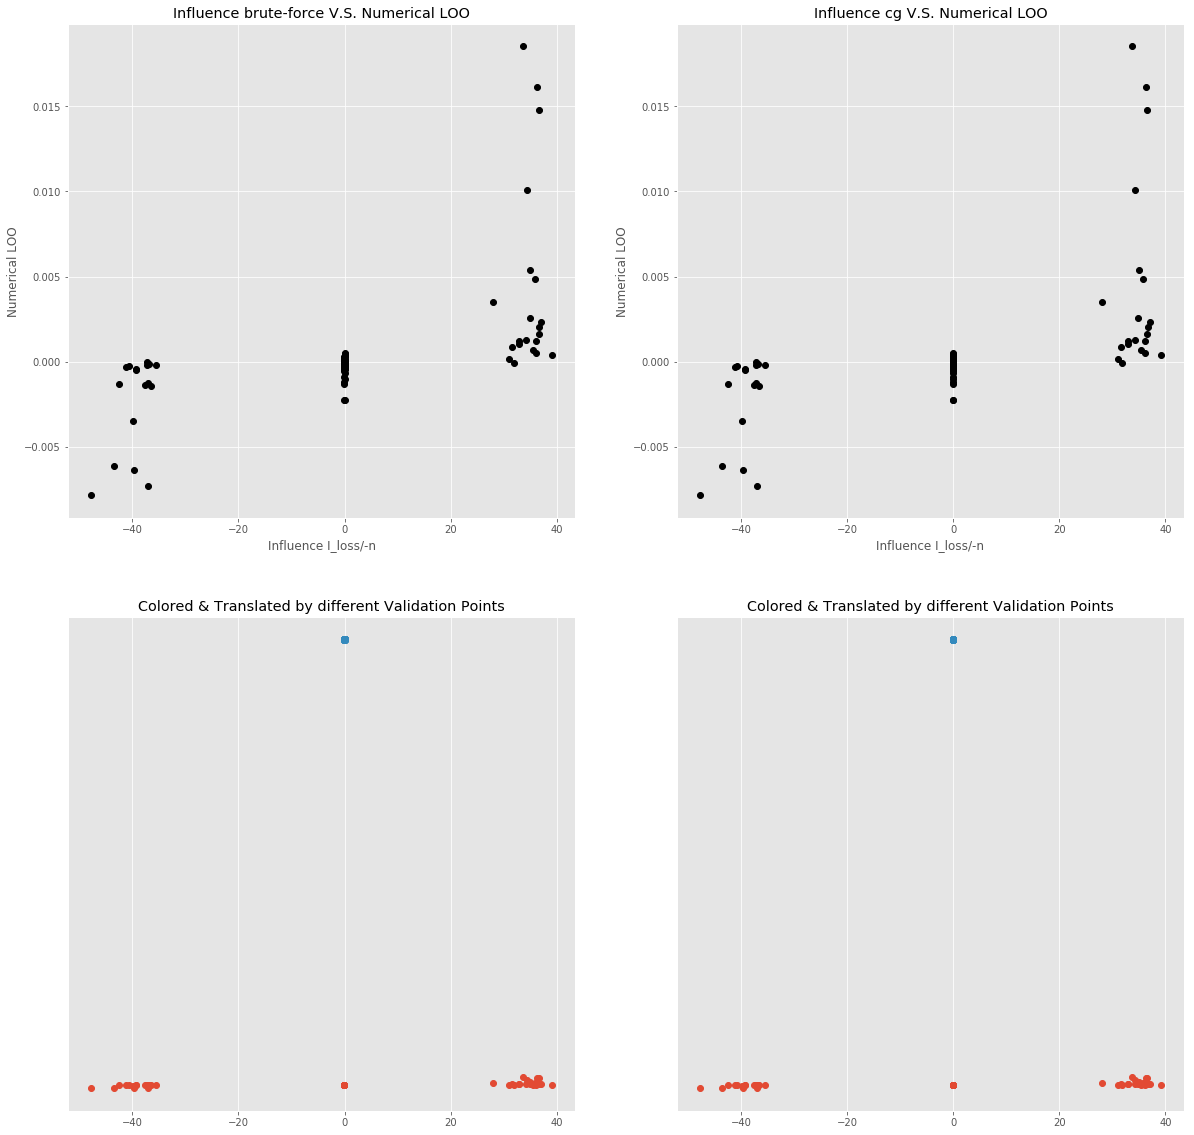

In [367]:
fig, axes = compare_with_loo(
    [I_loss_bf1, I_loss_bf1],
    loo_diff1, n_samples=n_tr
)
plt.savefig('IlossVSloo_t=0.eps', format='eps', dpi=1000)

In [341]:
a, b = loo_diff.shape
for j in range(n_te):
    print("Test Point %d Correlation: %.4f" % (j, np.corrcoef(
        I_loss_bf1[:, j], loo_diff[:, j])[0][1]))
print("Overall Correlation: %.4f" % np.corrcoef(
        I_loss_bf1[:, :].reshape(a*b,),
        loo_diff.reshape(a*b,))[0][1])

Test Point 0 Correlation: 0.7535
Test Point 1 Correlation: 0.7483
Overall Correlation: 0.7486


# t = 0.1

In [331]:
tf.reset_default_graph()
model2 = SmoothedSupportVector(
    model_name='SmoothHinge-Notebook',
    init_eta=init_eta,
    decay_epochs=decay_epochs,
    batch_size=batch_size,
    C=C,
    t=0.1
)
model2.fit(
    X_train, y_train,
    n_iter=train_iter,
    verbose=1,
    iter_to_switch_off_minibatch=iter_to_switch_off_minibatch,
    iter_to_switch_to_sgd=iter_to_switch_to_sgd,
    traceback_checkpoint=traceback_checkpoint
)

Step 0, Epoch 0: loss = 1.00000465 (0.106 sec)
Step 1000, Epoch 510: loss = 0.33500770 (0.001 sec)
Step 2000, Epoch 1020: loss = 0.33090591 (0.001 sec)
Step 3000, Epoch 1530: loss = 0.26268840 (0.001 sec)
Step 4000, Epoch 2040: loss = 0.28942916 (0.002 sec)
Step 5000, Epoch 2551: loss = 0.19536576 (0.001 sec)
Step 6000, Epoch 3061: loss = 0.26287654 (0.001 sec)
Step 7000, Epoch 3571: loss = 0.38260761 (0.001 sec)
Step 8000, Epoch 4081: loss = 0.27416623 (0.002 sec)
Step 9000, Epoch 4591: loss = 0.34431154 (0.002 sec)
Step 10000, Epoch 5102: loss = 0.38153869 (0.001 sec)
Step 11000, Epoch 5612: loss = 0.24590848 (0.003 sec)
Step 12000, Epoch 6122: loss = 0.29802990 (0.001 sec)
Step 13000, Epoch 6632: loss = 0.27315611 (0.001 sec)
Step 14000, Epoch 7142: loss = 0.33458221 (0.001 sec)
Step 15000, Epoch 7653: loss = 0.27930364 (0.001 sec)
Step 16000, Epoch 8163: loss = 0.30429915 (0.001 sec)
Step 17000, Epoch 8673: loss = 0.27319267 (0.001 sec)
Step 18000, Epoch 9183: loss = 0.34524095 (0.

SmoothHinge-Notebook(init_eta=0.01,batch_size=50,decay_epochs=(10000, 20000),C=1.0,t=0.1)

In [332]:
I_loss_bf2 = model2.influence_loss(
    X_test, y_test,
    method='brute-force',
)

loo_diff2 = model2.leave_one_out_refit(
    X_test, y_test,
    n_iter=loo_extra_iter,
    iter_to_load=checkpoint_iter,
    leave_indices=leave_indices,
)

Fetch training loss gradients (0.096 sec)
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
LOO Fold 0: loss = 0.29889527 (3.816 sec)
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
LOO Fold 9: loss = 0.29767463 (4.269 sec)
INFO

INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
LOO Fold 90: loss = 0.29889274 (3.417 sec)
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999


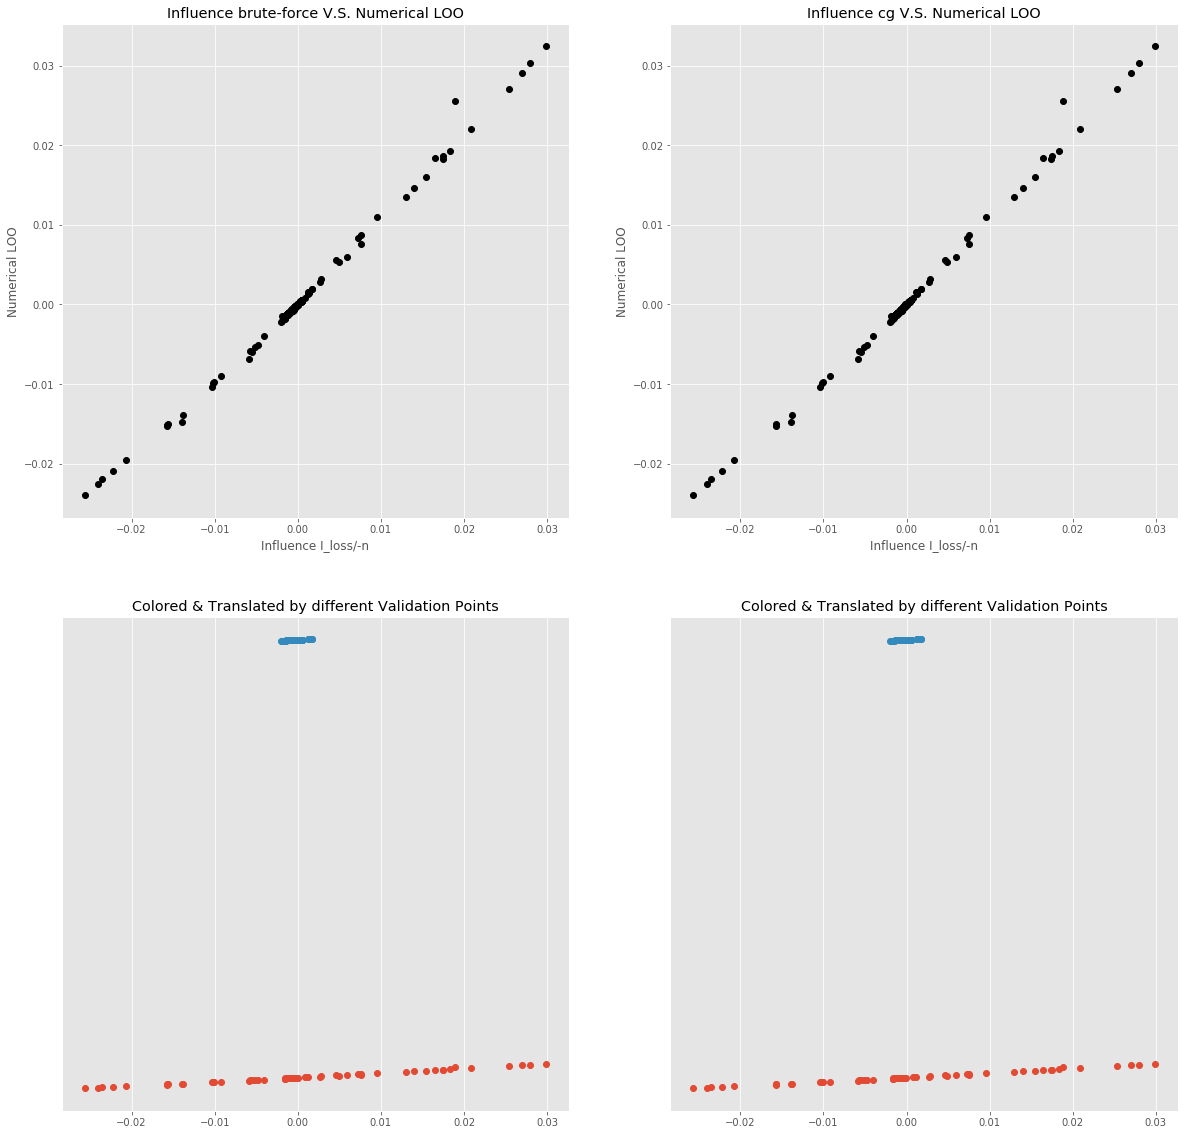

In [368]:
fig, axes = compare_with_loo(
    [I_loss_bf2, I_loss_bf2],
    loo_diff2, n_samples=n_tr
)
plt.savefig('IlossVSloo_t=01.eps', format='eps', dpi=1000)

In [335]:
a, b = loo_diff.shape
for j in range(n_te):
    print("Test Point %d Correlation: %.4f" % (j, np.corrcoef(
        I_loss_bf2[:, j], loo_diff[:, j])[0][1]))
print("Overall Correlation: %.4f" % np.corrcoef(
        I_loss_bf2[:, :].reshape(a*b,),
        loo_diff.reshape(a*b,))[0][1])

Test Point 0 Correlation: 0.8676
Test Point 1 Correlation: 0.7994
Overall Correlation: 0.8621


# t = 0.001

In [307]:
tf.reset_default_graph()
model3 = SmoothedSupportVector(
    model_name='SmoothHinge-Notebook',
    init_eta=init_eta,
    decay_epochs=decay_epochs,
    batch_size=batch_size,
    C=C,
    t=0.001
)
model3.fit(
    X_train, y_train,
    n_iter=train_iter,
    verbose=1,
    iter_to_switch_off_minibatch=iter_to_switch_off_minibatch,
    iter_to_switch_to_sgd=iter_to_switch_to_sgd,
    traceback_checkpoint=traceback_checkpoint
)

Step 0, Epoch 0: loss = 1.00000000 (0.134 sec)
Step 1000, Epoch 510: loss = 0.34257013 (0.001 sec)
Step 2000, Epoch 1020: loss = 0.32803234 (0.001 sec)
Step 3000, Epoch 1530: loss = 0.33207729 (0.002 sec)
Step 4000, Epoch 2040: loss = 0.34102094 (0.001 sec)
Step 5000, Epoch 2551: loss = 0.36593974 (0.002 sec)
Step 6000, Epoch 3061: loss = 0.24391979 (0.001 sec)
Step 7000, Epoch 3571: loss = 0.29820317 (0.001 sec)
Step 8000, Epoch 4081: loss = 0.27890366 (0.002 sec)
Step 9000, Epoch 4591: loss = 0.25679910 (0.001 sec)
Step 10000, Epoch 5102: loss = 0.30012360 (0.001 sec)
Step 11000, Epoch 5612: loss = 0.26367375 (0.001 sec)
Step 12000, Epoch 6122: loss = 0.31981561 (0.001 sec)
Step 13000, Epoch 6632: loss = 0.29111955 (0.001 sec)
Step 14000, Epoch 7142: loss = 0.33873671 (0.001 sec)
Step 15000, Epoch 7653: loss = 0.33911109 (0.001 sec)
Step 16000, Epoch 8163: loss = 0.29979664 (0.001 sec)
Step 17000, Epoch 8673: loss = 0.28353271 (0.002 sec)
Step 18000, Epoch 9183: loss = 0.32013121 (0.

SmoothHinge-Notebook(init_eta=0.01,batch_size=50,decay_epochs=(10000, 20000),C=1.0,t=0.001)

In [319]:
I_loss_bf3 = model3.influence_loss(
    X_test, y_test,
    method='brute-force',
)

Fetch training loss gradients (0.100 sec)


In [310]:
loo_diff3 = model3.leave_one_out_refit(
    X_test, y_test,
    n_iter=loo_extra_iter,
    iter_to_load=checkpoint_iter,
    leave_indices=leave_indices,
)

INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
LOO Fold 0: loss = 0.28963733 (3.512 sec)
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
LOO Fold 9: loss = 0.28924099 (3.455 sec)
INFO:tensorflow:Restoring parameters from outp

INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
LOO Fold 90: loss = 0.28963733 (3.432 sec)
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999


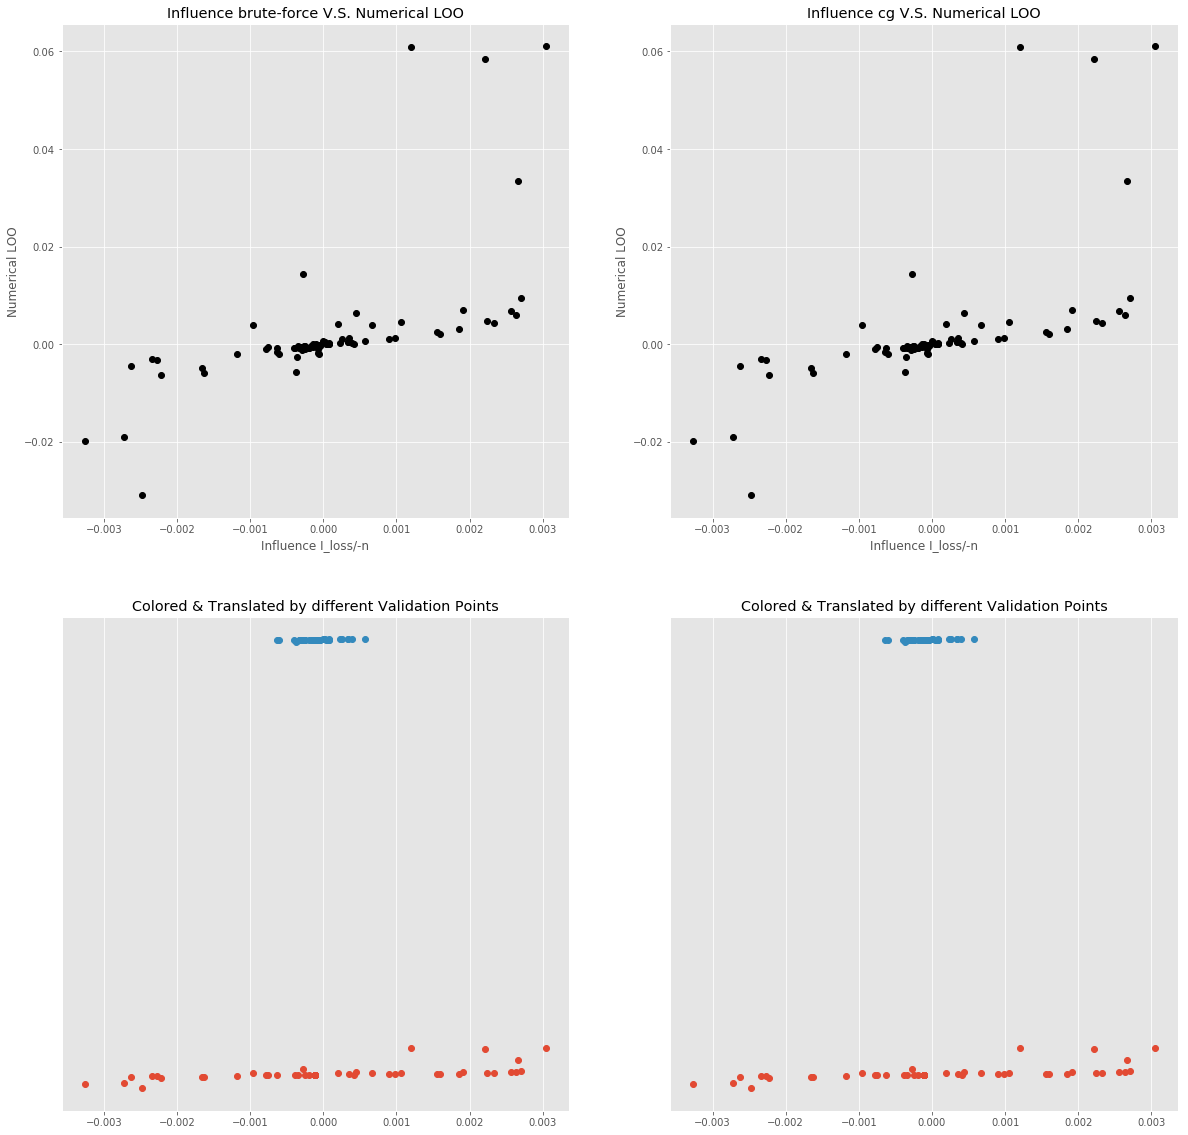

In [370]:
fig, axes = compare_with_loo(
    [I_loss_bf3, I_loss_bf3],
    loo_diff3, n_samples=n_tr
)
plt.savefig('IlossVSloo_t=0001.eps', format='eps', dpi=1000)

In [320]:
a, b = loo_diff.shape
for j in range(n_te):
    print("Test Point %d Correlation: %.4f" % (j, np.corrcoef(
        I_loss_bf3[:, j], loo_diff[:, j])[0][1]))
print("Overall Correlation: %.4f" % np.corrcoef(
        I_loss_bf3[:, :].reshape(a*b,),
        loo_diff.reshape(a*b,))[0][1])

Test Point 0 Correlation: 0.7935
Test Point 1 Correlation: 0.7133
Overall Correlation: 0.7855


## t = 0.01

In [322]:
tf.reset_default_graph()
model4 = SmoothedSupportVector(
    model_name='SmoothHinge-Notebook',
    init_eta=init_eta,
    decay_epochs=decay_epochs,
    batch_size=batch_size,
    C=C,
    t=0.01
)
model4.fit(
    X_train, y_train,
    n_iter=train_iter,
    verbose=1,
    iter_to_switch_off_minibatch=iter_to_switch_off_minibatch,
    iter_to_switch_to_sgd=iter_to_switch_to_sgd,
    traceback_checkpoint=traceback_checkpoint
)

Step 0, Epoch 0: loss = 1.00000000 (0.181 sec)
Step 1000, Epoch 510: loss = 0.38272735 (0.001 sec)
Step 2000, Epoch 1020: loss = 0.26465681 (0.002 sec)
Step 3000, Epoch 1530: loss = 0.26815900 (0.002 sec)
Step 4000, Epoch 2040: loss = 0.30137214 (0.002 sec)
Step 5000, Epoch 2551: loss = 0.35978660 (0.001 sec)
Step 6000, Epoch 3061: loss = 0.35471752 (0.001 sec)
Step 7000, Epoch 3571: loss = 0.28679463 (0.002 sec)
Step 8000, Epoch 4081: loss = 0.36137736 (0.002 sec)
Step 9000, Epoch 4591: loss = 0.27695161 (0.001 sec)
Step 10000, Epoch 5102: loss = 0.31742683 (0.001 sec)
Step 11000, Epoch 5612: loss = 0.27095643 (0.002 sec)
Step 12000, Epoch 6122: loss = 0.34383652 (0.001 sec)
Step 13000, Epoch 6632: loss = 0.28648400 (0.001 sec)
Step 14000, Epoch 7142: loss = 0.29898465 (0.001 sec)
Step 15000, Epoch 7653: loss = 0.25198558 (0.001 sec)
Step 16000, Epoch 8163: loss = 0.25611407 (0.002 sec)
Step 17000, Epoch 8673: loss = 0.22961256 (0.002 sec)
Step 18000, Epoch 9183: loss = 0.21128367 (0.

SmoothHinge-Notebook(init_eta=0.01,batch_size=50,decay_epochs=(10000, 20000),C=1.0,t=0.01)

In [323]:
I_loss_bf4 = model4.influence_loss(
    X_test, y_test,
    method='brute-force',
)

loo_diff4 = model4.leave_one_out_refit(
    X_test, y_test,
    n_iter=loo_extra_iter,
    iter_to_load=checkpoint_iter,
    leave_indices=leave_indices,
)

Fetch training loss gradients (0.076 sec)
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
LOO Fold 0: loss = 0.28993386 (3.779 sec)
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
LOO Fold 9: loss = 0.28942955 (3.340 sec)
INFO

INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
LOO Fold 90: loss = 0.28993386 (3.659 sec)
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999
INFO:tensorflow:Restoring parameters from output\SmoothHinge-Notebook-checkpoint-44999


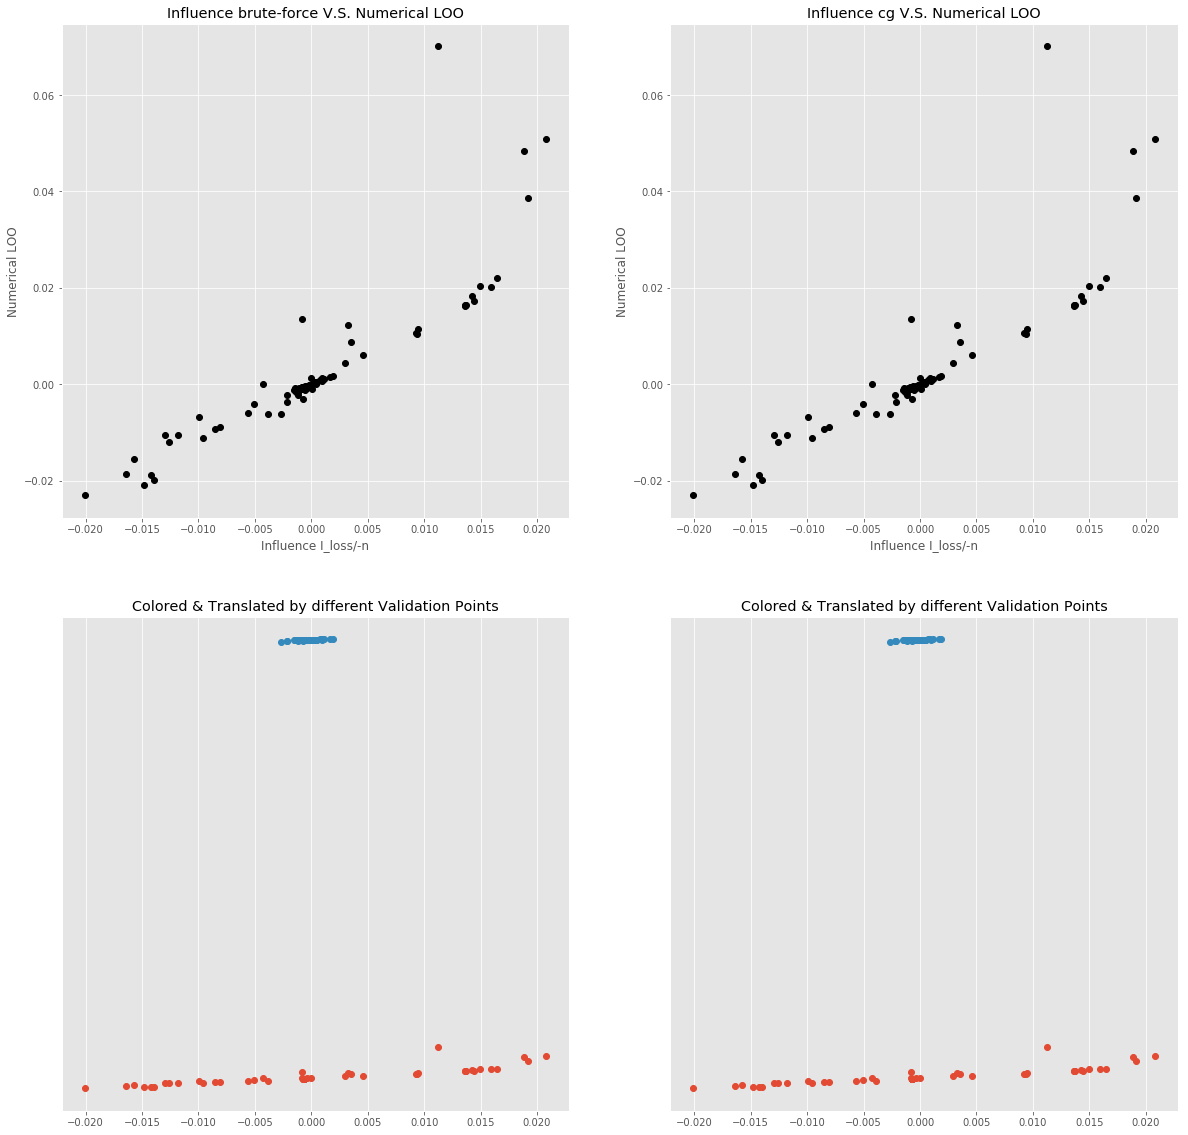

In [369]:
fig, axes = compare_with_loo(
    [I_loss_bf4, I_loss_bf4],
    loo_diff4, n_samples=n_tr
)
plt.savefig('IlossVSloo_t=001.eps', format='eps', dpi=1000)

In [326]:
a, b = loo_diff.shape
for j in range(n_te):
    print("Test Point %d Correlation: %.4f" % (j, np.corrcoef(
        I_loss_bf4[:, j], loo_diff[:, j])[0][1]))
print("Overall Correlation: %.4f" % np.corrcoef(
        I_loss_bf4[:, :].reshape(a*b,),
        loo_diff4.reshape(a*b,))[0][1])

Test Point 0 Correlation: 0.8704
Test Point 1 Correlation: 0.9103
Overall Correlation: 0.8654


# Comparison

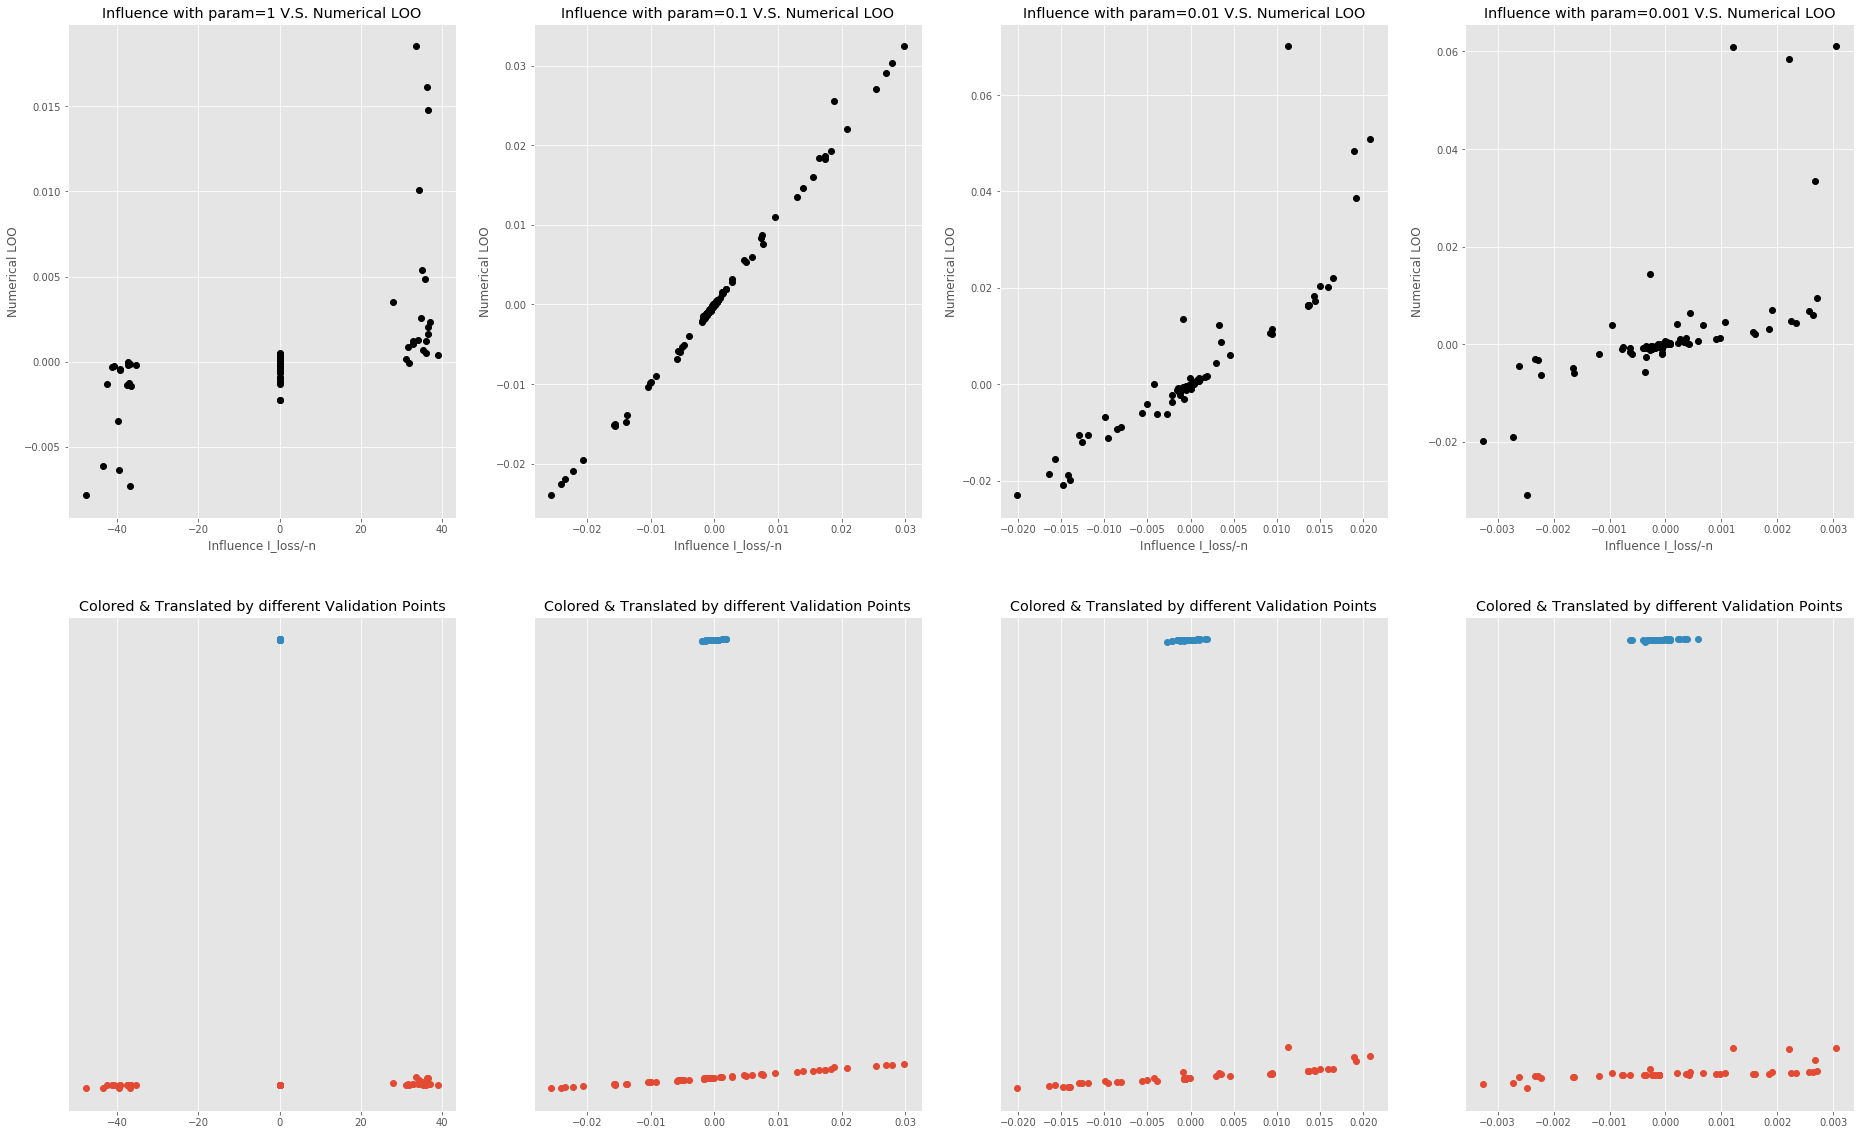

In [371]:
fig, axes = param_cross_comparison(
    [I_loss_bf1, I_loss_bf2, I_loss_bf4, I_loss_bf3],
    [loo_diff1, loo_diff2, loo_diff4, loo_diff3], n_tr, [1, 0.1, 0.01, 0.001]
)
plt.savefig('IlossVSloo_cross_comparison.eps', format='eps', dpi=1000)

# Application

One application of influence function is that it can help us to determine which the importance of different data point in our model to make prediction. In this part, we will show two experiments. Firstly, we will show how different data points in a dataset can have different influence in linearSVM model. Secondly, we will see how the same dataset can have different influence in linearSVM model and Logistic Regression model.

## Using Influence function to gain insights about SVM

Using Iris dataset, we plot the influence of the data with respect to euclidean distance of the data to the hyperplane.

We find out that if the closer the data is to the hyperplace, the more influence it will have in the model. And  as the data moves away from the model, its influence will become almost zero at some time. This matches closely to what we know about linearSVM that the hyperplane are defined by the support vectors and if we remove data points that are not support vectors, the classfier will not be affected.

## Vanilla Dataset (may not be used)

In vanilla dataset, we use simple simulated 2d data.

In [351]:
df = pd.read_csv('data/hyperplane_2.csv')
n = len(df)
X_vanilla = df.values[:, 0:2]
y_vanilla = df.values[:, -1].reshape(n, 1)
n, p = X_vanilla.shape

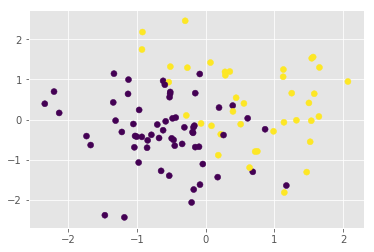

In [372]:
plt.scatter(X_vanilla[:,0], X_vanilla[:,1], c=y_vanilla[:,0])
plt.savefig('svm_vanilla_raw.eps', format='eps', dpi=1000)

In [361]:
tf.reset_default_graph()

init_eta = 1e-2
batch_size = 40
train_iter = 50000
traceback_checkpoint = 45000
loo_extra_iter = 5000
decay_epochs = (10000, 20000)
checkpoint_iter = traceback_checkpoint-1
iter_to_switch_off_minibatch=20000
iter_to_switch_to_sgd=40000
C = 1.0
t = 0.001
leave_indices = None
print(leave_indices)

model5 = SmoothedSupportVector(
    model_name='SmoothHinge-Notebook',
    init_eta=init_eta,
    decay_epochs=decay_epochs,
    batch_size=batch_size,
    C=C,
    t=t
)
model5.fit(
    X_vanilla, y_vanilla,
    n_iter=train_iter,
    verbose=1,
    iter_to_switch_off_minibatch=iter_to_switch_off_minibatch,
    iter_to_switch_to_sgd=iter_to_switch_to_sgd,
    traceback_checkpoint=traceback_checkpoint
)

None
Step 0, Epoch 0: loss = 1.00000000 (0.118 sec)
Step 1000, Epoch 400: loss = 0.74720925 (0.001 sec)
Step 2000, Epoch 800: loss = 0.74778008 (0.001 sec)
Step 3000, Epoch 1200: loss = 0.79908669 (0.001 sec)
Step 4000, Epoch 1600: loss = 0.70145881 (0.001 sec)
Step 5000, Epoch 2000: loss = 0.74250078 (0.001 sec)
Step 6000, Epoch 2400: loss = 0.78098738 (0.001 sec)
Step 7000, Epoch 2800: loss = 0.68921649 (0.001 sec)
Step 8000, Epoch 3200: loss = 0.79875743 (0.001 sec)
Step 9000, Epoch 3600: loss = 0.76542044 (0.001 sec)
Step 10000, Epoch 4000: loss = 0.78227395 (0.003 sec)
Step 11000, Epoch 4400: loss = 0.73613387 (0.001 sec)
Step 12000, Epoch 4800: loss = 0.61327398 (0.002 sec)
Step 13000, Epoch 5200: loss = 0.74455309 (0.001 sec)
Step 14000, Epoch 5600: loss = 0.84897280 (0.001 sec)
Step 15000, Epoch 6000: loss = 0.69479591 (0.001 sec)
Step 16000, Epoch 6400: loss = 0.78736818 (0.001 sec)
Step 17000, Epoch 6800: loss = 0.74789590 (0.001 sec)
Step 18000, Epoch 7200: loss = 0.72746032

SmoothHinge-Notebook(init_eta=0.01,batch_size=40,decay_epochs=(10000, 20000),C=1.0,t=0.001)

In [362]:
I_loss_bf5 = model5.influence_loss(
    X_vanilla, y_vanilla,
    method='brute-force',
)

Fetch training loss gradients (0.091 sec)


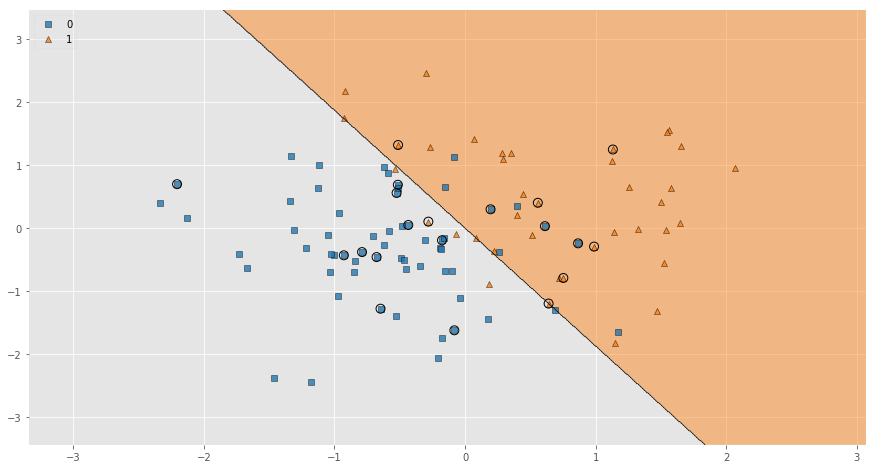

In [391]:
fig,_ = plt.subplots(figsize=(15,8))
abs_mean_i_loss = np.abs(sum(I_loss_bf5)/sum(sum(I_loss_bf5)))
plot_decision_regions(X_vanilla, y_vanilla.astype(int).reshape(100,), X_highlight=X_vanilla[np.argsort(-abs_mean_i_loss)[0:20]], clf=model5, legend=2)
plt.savefig('svm_vanilla_decision_region.eps', format='eps', dpi=1000)

## Iris Dataset

We use Iris data here.

In [2]:
tf.reset_default_graph()

# [6, 47]
X_train, X_test, y_train, y_test, test_indices = load_data(
    Datafile.Iris, test_config=0.2)
n_tr, p = X_train.shape
n_te, _ = X_test.shape
print(n_tr, p)

X_train shape: (80, 4)
y_train shape: (80, 1)
X_test shape: (20, 4)
y_test shape: (20, 1)
80 4


In [11]:
tf.reset_default_graph()
init_eta = 1e-2
batch_size = 50
train_iter = 50000
traceback_checkpoint = 45000
loo_extra_iter = 5000
decay_epochs = (10000, 20000)
checkpoint_iter = traceback_checkpoint-1
iter_to_switch_off_minibatch=20000
iter_to_switch_to_sgd=40000
C = 1.0
t = 0.01
# LOO a on random set of training indices, otherwise too slow
leave_indices = None
#assert not set(test_indices) & set(leave_indices)
#print(test_indices)
print(leave_indices)

model = SmoothedSupportVector(
    model_name='SmoothHinge-Notebook',
    init_eta=init_eta,
    decay_epochs=decay_epochs,
    batch_size=batch_size,
    C=C,
    t=0.1
)
model.fit(
    X_train, y_train,
    n_iter=train_iter,
    verbose=1,
    iter_to_switch_off_minibatch=iter_to_switch_off_minibatch,
    iter_to_switch_to_sgd=iter_to_switch_to_sgd,
    traceback_checkpoint=traceback_checkpoint
)

None
Step 0, Epoch 0: loss = 1.00000465 (0.094 sec)
Step 1000, Epoch 555: loss = 0.25837529 (0.000 sec)
Step 2000, Epoch 1111: loss = 0.26668587 (0.000 sec)
Step 3000, Epoch 1666: loss = 0.25100890 (0.016 sec)
Step 4000, Epoch 2222: loss = 0.35715064 (0.000 sec)
Step 5000, Epoch 2777: loss = 0.27925462 (0.000 sec)
Step 6000, Epoch 3333: loss = 0.25635117 (0.000 sec)
Step 7000, Epoch 3888: loss = 0.27573329 (0.000 sec)
Step 8000, Epoch 4444: loss = 0.33854485 (0.000 sec)
Step 9000, Epoch 4999: loss = 0.27032584 (0.000 sec)
Step 10000, Epoch 5555: loss = 0.35625950 (0.000 sec)
Step 11000, Epoch 6111: loss = 0.31712601 (0.000 sec)
Step 12000, Epoch 6666: loss = 0.24386424 (0.000 sec)
Step 13000, Epoch 7222: loss = 0.27839229 (0.000 sec)
Step 14000, Epoch 7777: loss = 0.26214594 (0.000 sec)
Step 15000, Epoch 8333: loss = 0.29090616 (0.000 sec)
Step 16000, Epoch 8888: loss = 0.22538944 (0.016 sec)
Step 17000, Epoch 9444: loss = 0.26992378 (0.000 sec)
Step 18000, Epoch 9999: loss = 0.2842217

SmoothHinge-Notebook(init_eta=0.01,batch_size=50,decay_epochs=(10000, 20000),C=1.0,t=0.1)

In [12]:
I_loss_bf5 = model.influence_loss(
    X_train, y_train,
    method='brute-force',
)
mean_i_loss = sum(I_loss_bf5)/sum(sum(I_loss_bf5))

Fetch training loss gradients (0.109 sec)


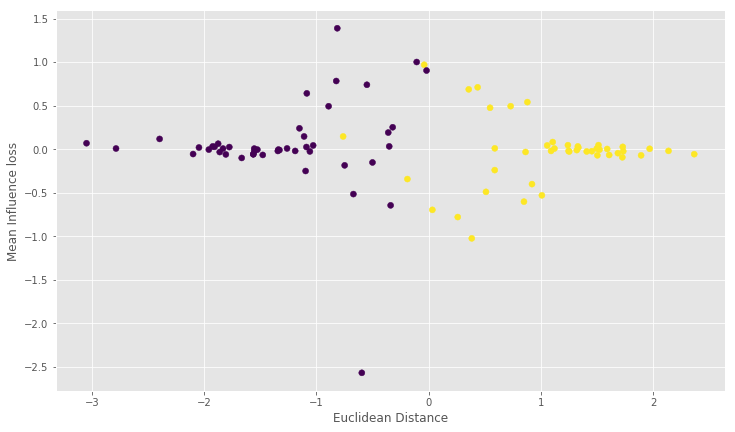

In [13]:
fig,axis = plt.subplots(figsize = (12,7))
beta = model.get_eval(items=['params'])['beta']
euclidean_dist = X_train.dot(beta)
plt.scatter(euclidean_dist.flatten(), mean_i_loss, c=y_train[:,0])
plt.xlabel('Euclidean Distance')
plt.ylabel('Mean Influence loss')
plt.savefig('svm_iris_distanceVSinfluence.eps', format='eps', dpi=1000)

## Logistic Regression vs. LinearSVM

From plots below, we can see some interesting things. 

We see that in LinearSVM, when data are some distance away from the hyperplane at some threshold (i.e. not support vector), the influence will decrease to zero. In Logistic Regression, we can see that different from LinearSVM, all data will have influence even though the influence of data will decrease as distance from the hyperplance increases.

We also see that data near the hypterplane will have more influence in LinearSVM than those in Logistic Regression.
In conclusion, data in Logistic Regression contributes in a more "average" way than LinearSVM.

In [9]:
X_train, X_test, y_train, y_test, test_indices = load_data(
    Datafile.Iris, test_config=10)
n_tr, p = X_train.shape
n_te, _ = X_test.shape
y_train[y_train==0]=-1 
y_test[y_test==0]=-1
print(n_tr, p)

X_train shape: (90, 4)
y_train shape: (90, 1)
X_test shape: (10, 4)
y_test shape: (10, 1)
90 4


In [14]:
tf.reset_default_graph()

y_train[y_train==0]=-1
y_test[y_test==0]=-1

init_eta = 1e-2
batch_size = 50
train_iter = 50000
traceback_checkpoint = 45000
loo_extra_iter = 5000
decay_epochs = (10000, 20000)
checkpoint_iter = traceback_checkpoint-1
iter_to_switch_off_minibatch=20000
iter_to_switch_to_sgd=40000
C = 1.0
t = 0.01
# LOO a on random set of training indices, otherwise too slow
leave_indices = None
#assert not set(test_indices) & set(leave_indices)
#print(test_indices)
print(leave_indices)

svm_model = SmoothedSupportVector(
    model_name='SmoothHinge-Notebook',
    init_eta=init_eta,
    decay_epochs=decay_epochs,
    batch_size=batch_size,
    C=C,
    t=0.1
)
svm_model.fit(
    X_train, y_train,
    n_iter=train_iter,
    verbose=1,
    iter_to_switch_off_minibatch=iter_to_switch_off_minibatch,
    iter_to_switch_to_sgd=iter_to_switch_to_sgd,
    traceback_checkpoint=traceback_checkpoint
)

None
Step 0, Epoch 0: loss = 1.00000465 (0.203 sec)
Step 1000, Epoch 555: loss = 0.32040039 (0.000 sec)
Step 2000, Epoch 1111: loss = 0.31471121 (0.000 sec)
Step 3000, Epoch 1666: loss = 0.31293029 (0.000 sec)
Step 4000, Epoch 2222: loss = 0.29352462 (0.000 sec)
Step 5000, Epoch 2777: loss = 0.26753086 (0.000 sec)
Step 6000, Epoch 3333: loss = 0.26228192 (0.000 sec)
Step 7000, Epoch 3888: loss = 0.28555384 (0.000 sec)
Step 8000, Epoch 4444: loss = 0.31586030 (0.000 sec)
Step 9000, Epoch 4999: loss = 0.27421626 (0.000 sec)
Step 10000, Epoch 5555: loss = 0.32951316 (0.000 sec)
Step 11000, Epoch 6111: loss = 0.32558745 (0.000 sec)
Step 12000, Epoch 6666: loss = 0.28824756 (0.000 sec)
Step 13000, Epoch 7222: loss = 0.28632107 (0.000 sec)
Step 14000, Epoch 7777: loss = 0.32341573 (0.000 sec)
Step 15000, Epoch 8333: loss = 0.28516924 (0.000 sec)
Step 16000, Epoch 8888: loss = 0.32503575 (0.000 sec)
Step 17000, Epoch 9444: loss = 0.26569188 (0.000 sec)
Step 18000, Epoch 9999: loss = 0.2897361

SmoothHinge-Notebook(init_eta=0.01,batch_size=50,decay_epochs=(10000, 20000),C=1.0,t=0.1)

In [15]:
y_pred = svm_model.predict(X_train)
print("Train accuracy:", np.sum(y_pred == y_train)/n_tr)

y_pred_test = svm_model.predict(X_test)
print("Test accuracy:", np.sum(y_pred_test == y_test)/len(y_test))

Train accuracy: 0.9666666666666667
Test accuracy: 0.9


In [16]:
I_loss_bf_svm = svm_model.influence_loss(
    X_test, y_test,
    method='brute-force',
)
mean_i_loss_svm = sum(I_loss_bf_svm)

Fetch training loss gradients (0.094 sec)


In [17]:
tf.reset_default_graph()

y_train[y_train==-1]=0
y_test[y_test==-1]=0

init_eta = 0.01
batch_size = 30
train_iter = 50000
traceback_checkpoint = 45000
loo_extra_iter = 5000
decay_epochs = (10000, 20000)
checkpoint_iter = traceback_checkpoint-1
iter_to_switch_off_minibatch=35000
iter_to_switch_to_sgd=np.inf
# LOO a on random set of training indices, otherwise too slow
leave_indices = None

if hasattr(test_indices, '__iter__') and hasattr(leave_indices, '__iter__'):
    assert not set(test_indices) & set(leave_indices)
    print(test_indices)
    print(leave_indices)

blr_model = BinaryLogisticRegression(
    model_name='BinaryLogistic-Notebook',
    init_eta=init_eta,
    decay_epochs=decay_epochs,
    batch_size=batch_size,
    C=10.0
)


"""
blr_model.fit(
    X_train, y_train,
    n_iter=train_iter,
    verbose=1,
    iter_to_switch_off_minibatch=iter_to_switch_off_minibatch,
    iter_to_switch_to_sgd=iter_to_switch_to_sgd,
    traceback_checkpoint=traceback_checkpoint
)
"""

blr_model.fit_with_sklearn(
    {'X':X_train, 'y':y_train}
)


Model Evaluations:
------------------------------------------
Empirical Risk: 0.650175
Norm of Params: 1.232589
Norm of Gradient: 0.136954


BinaryLogistic-Notebook(init_eta=0.01,batch_size=30,decay_epochs=(10000, 20000),C=10.0)

In [18]:
y_pred = blr_model.predict(X_train)
print("Train accuracy:", np.sum(y_pred == y_train)/len(y_train))

y_pred_test = blr_model.predict(X_test)
print("Test accuracy:", np.sum(y_pred_test == y_test)/len(y_test))

Train accuracy: 0.9444444444444444
Test accuracy: 0.9


In [21]:
I_loss_bf_blr = blr_model.influence_loss(
    X_test, y_test,
    method='brute-force',
)
mean_i_loss_blr = sum(I_loss_bf_blr)

Fetch training loss gradients (0.078 sec)


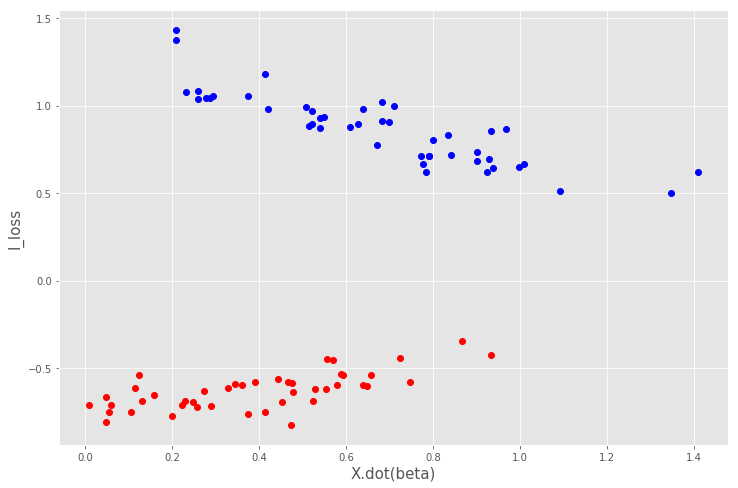

In [29]:
fig,ax = plt.subplots(figsize=(12,8))
for i in range(1):
    plt.plot(np.abs(X_train.dot(beta_blr))[y_train==1], 
            I_loss_bf_blr[:,i:i+1][y_train==1], 'o', color='red')
    plt.plot(np.abs(X_train.dot(beta_blr))[y_train==0], 
            I_loss_bf_blr[:,i:i+1][y_train==0], 'o', color='blue')
plt.xlabel('X.dot(beta)', fontsize=15)
plt.ylabel('I_loss', fontsize=15)
plt.savefig('iris_logisticVSsvm_logistic.eps', format='eps', dpi=1000)

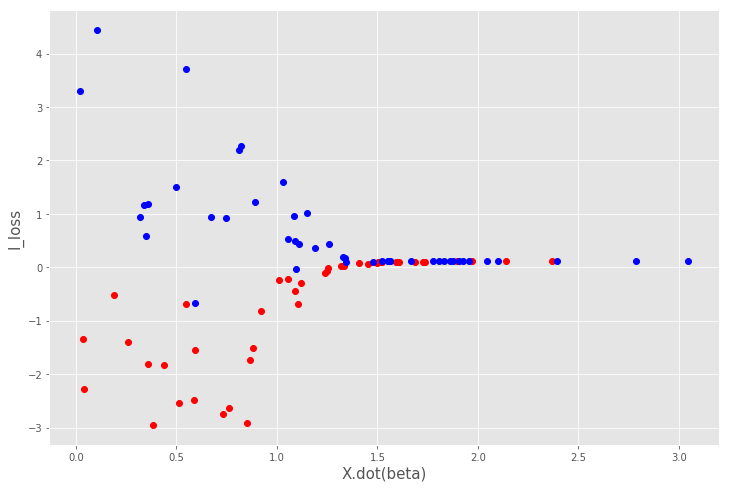

In [30]:
fig,ax = plt.subplots(figsize=(12,8))
for i in range(1):
    plt.plot(np.abs(X_train.dot(beta_svm))[y_train==1], 
            I_loss_bf_svm[:,i:i+1][y_train==1], 'o', color='red')
    plt.plot(np.abs(X_train.dot(beta_svm))[y_train==0], 
            I_loss_bf_svm[:,i:i+1][y_train==0], 'o', color='blue')
plt.xlabel('X.dot(beta)', fontsize=15)
plt.ylabel('I_loss', fontsize=15)
plt.savefig('iris_logisticVSsvm_svm.eps', format='eps', dpi=1000)

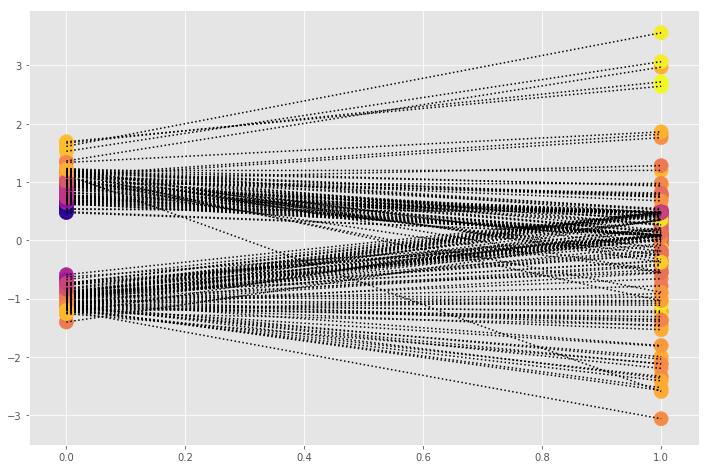

In [31]:
fig, ax = plt.subplots(figsize=(12,8))

beta_blr = blr_model.get_eval(items=['params'])['beta']
euclidean_dist_blr = StandardScaler().fit_transform(
    abs(X_train.dot(beta_blr)))

beta_svm = svm_model.get_eval(items=['params'])['beta']
euclidean_dist_svm = StandardScaler().fit_transform(
    abs(X_train.dot(beta_svm)))

"""
for i in range(80):
    norm_iloss_blr = StandardScaler().fit_transform(I_loss_bf_blr[:,i:i+1])
    norm_iloss_svm = StandardScaler().fit_transform(I_loss_bf_svm[:,i:i+1])
    plt.scatter(np.zeros(len(mean_i_loss_blr)),
            norm_iloss_blr, c = -euclidean_dist_blr[:,0],
            cmap=plt.get_cmap('viridis'), s=200)
    plt.scatter(np.ones(len(mean_i_loss_svm)),
                norm_iloss_svm, c = -euclidean_dist_svm[:,0],
                cmap=plt.get_cmap('viridis'), s=200)
"""



for i in range(2):
    norm_iloss_blr = StandardScaler().fit_transform(
        I_loss_bf_blr[:,i:i+1])
    norm_iloss_svm = StandardScaler().fit_transform(
        I_loss_bf_svm[:,i:i+1])
    plt.scatter(np.zeros(n_tr),
                norm_iloss_blr, c = -euclidean_dist_blr[:,0],
                cmap=plt.get_cmap('plasma'), s=200)
    plt.scatter(np.ones(n_tr),
                norm_iloss_svm, c = -euclidean_dist_svm[:,0],
                cmap=plt.get_cmap('plasma'), s=200)


    for i in range(len(norm_iloss_blr)):
        plt.plot([0,1], [norm_iloss_blr[i], norm_iloss_svm[i]], 'k:')
plt.savefig('iris_logisticVSsvm_dotted.eps', format='eps', dpi=1000)

In [184]:
df = pd.DataFrame({'influence':norm_iloss_svm, 'distance':euclidean_dist_svm[:,0]})
# df.groupby(pd.cut(df["distance"], np.arange(-1, 3, 0.1))).sum()

In [183]:
df = pd.DataFrame({'influence':norm_iloss_blr, 'distance':euclidean_dist_blr[:,0]})
# df.groupby(pd.cut(df["distance"], np.arange(0, 3, 0.1))).sum()

In [151]:
beta1 = blr_model.get_eval(items=['params'])['beta']
beta2 = svm_model.get_eval(items=['params'])['beta']
print(beta1,beta2)

[[ 1.2242963]
 [ 1.296414 ]
 [-1.7951735]
 [-1.6542718]] [[0.16816868]
 [0.08068632]
 [0.1128763 ]
 [0.03594271]]
